# Formula 1 Radio Sentiment Analysis with Bert

In this notebook, two BERT models are implemented:

1. First one is a **trained BERT from sratch**.
2. Secondly, a **pre-trained BERT model** will be downloaded and fine-tuned with my team radios.

After some research, I decided to **not implement the first point**. Here is the explanation:

---

## 1. Sentiment Analysis for F1 Radio Messages: RoBERTa-base with Fine-tuning

### Why RoBERTa-base?

RoBERTa-base is our selected model for sentiment analysis of Formula 1 radio communications for the following reasons:

1. **Superior performance on sentiment classification**: RoBERTa consistently outperforms BERT in emotion detection tasks due to its improved training methodology and longer pretraining.

2. **Strong contextual understanding**: F1 radio messages contain technical jargon, specialized terminology, and driver/team codes that require deep semantic understanding to interpret correctly.

3. **Effective with specialized communications**: F1 radio messages typically feature:
   - Short, direct communications with minimal context.
   - Technical terminology and abbreviations (e.g., "box this lap", "DRS enabled").
   - High-pressure communications with non-standard sentence structures.
   - Team-specific codes and references.

4. **Better handling of domain-specific language**: RoBERTa's robust pretraining makes it more adaptable to specialized domains like motorsport communications.

---

### RoBERTa´s model architecture



RoBERTa (Robustly Optimized BERT Pretraining Approach) maintains the core Transformer architecture of BERT while introducing several key optimizations:

#### Core Components

1. **Input Processing**:
   - **RoBERTaFastTokenizer**: Efficiently converts text into tokens using Byte-Pair Encoding.
   - **Citation Re-insertion**: Handles special tokens and formatting.

2. **Encoder Stack**:
   - **Transformer Blocks**: 12 blocks (base) or 24 blocks (large) providing bidirectional context.
   - Each block contains multi-head self-attention and feed-forward neural networks.

3. **Classification Head**:
   - **Concatenation**: Combines [CLS] token representation with optional metadata.
   - **Feature Processing**: Series of linear transformations with dropout layers for regularization.
   - **Output Layer**: Final linear projection and softmax activation producing class probabilities.

<div align="center">
  <img src="../NLP_radio_processing//images/The-RoBERTa-model-architecture.jpg" alt="RoBERTa´s architecture" width="500"/>
</div>



#### Key Architectural Improvements Compared to BERT

- Removes BERT's Next Sentence Prediction (NSP) objective.
- Uses dynamic masking patterns during pretraining.
- Employs larger batch sizes and learning rates.
- Trains on 10× more data than BERT.



#### Reference
*Context-Aware Legal Citation Recommendation using Deep Learning - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/The-RoBERTa-model-architecture_fig2_352642553 [accessed 11 Mar 2025]*

---

### Why Fine-tuning Instead of Training from Scratch?

Training RoBERTa from scratch is impractical for our project due to:

- **Dataset size limitation**: Our dataset contains only 530 labeled examples, whereas training from scratch would require millions of examples (RoBERTa was pre-trained on ~160GB of text).

- **Computational requirements**: Training RoBERTa-base from scratch would require:
  - 8+ high-end GPUs (NVIDIA V100/A100).
  - 1-2 weeks of continuous training.
  - Approximately 200-400GB of GPU memory.
  - Estimated cost: $5,000-$10,000 on cloud providers.

- **Transfer learning advantage**: Fine-tuning leverages knowledge already encoded in pre-trained weights, requiring only ~2-4 hours on a single GPU to adapt to our F1 domain.

By fine-tuning RoBERTa-base, we can achieve excellent performance while utilizing the model's pre-existing understanding of language structure and sentiment, which is particularly valuable given our specialized domain and limited labeled data.

## 2. Import necessary libraries

In [223]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time
import datetime


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


---

## 3. Loading the RoBERTa model and also the tokenizer.

First, we need to download the RoBERTa model, with its correspondant tokenizer.

In [201]:
# Cell 2: Download the RoBERTa model and tokenizer
model_name = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,  # Assuming we have positive, negative, and neutral sentiments
    output_attentions=False,
    output_hidden_states=False,
)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [202]:
# Move model to the appropriate device (GPU if available)
model.to(device)
print(f"Model {model_name} loaded successfully")

Model roberta-base loaded successfully


--- 

#### Loading and preparing the data

In [203]:
# Cell 3: Load and prepare the data
# Load the CSV file
df = pd.read_csv('../../outputs/week4/radio_clean/radio_labeled_data.csv')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())



Dataset shape: (530, 3)

First few rows:
   driver                                      radio_message sentiment
0       1  So don't forget Max, use your head please. Are...   neutral
1       1  Okay Max, we're expecting rain in about 9 or 1...   neutral
2       1  You might find this lap that you meet a little...   neutral
3       1  Just another two or three minutes to get throu...   neutral
4       1   So settle into standard race management now Max.   neutral


In [204]:
# Check sentiment distribution
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Sentiment distribution:
sentiment
neutral     379
negative    101
positive     50
Name: count, dtype: int64


--- 
### Creating numeric variables.

I need to change the labelling to numeric labels, basing myself on numeric values. The next correlation will be made:

1. *Positive* will become a 0.
2. *Neutral* will become a 1.
3. *Negative* will become a 2.

In [205]:
# Create numeric labels based on sentiment values
sentiment_mapping = {
    'positive': 0, 
    'neutral': 1, 
    'negative': 2
}

# Apply mapping (adjust this based on your actual sentiment values)
df['label'] = df['sentiment'].map(sentiment_mapping)

# Check if we need to handle any missing mappings
if df['label'].isna().sum() > 0:
    print(f"\nWarning: {df['label'].isna().sum()} rows couldn't be mapped. Unique values in 'sentiment':")
    print(df['sentiment'].unique())


---

## 4. Creating the training, validation and test split.

I´ll follow the same splits techniques during the project, making a training, validation and test dataset.

* *Train* will be 70% of the dataset.
* *Validation*: will be 15% of the dataset.
* *Test*: will be 15% of the dataset.

In [206]:
# Cell 4: Create the train/validation/test split
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['radio_message'].values, 
    df['label'].values, 
    test_size=0.3,  # 30% for val+test
    random_state=42, 
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # 50% of the 30% (so 15% of total)
    random_state=42,
    stratify=temp_labels
)


In [207]:
print(f"Training set: {len(train_texts)} samples")
print(f"Validation set: {len(val_texts)} samples")
print(f"Test set: {len(test_texts)} samples")

Training set: 371 samples
Validation set: 79 samples
Test set: 80 samples


---

## 5. Next Step: Tokenizing



### Knowing the max lenght for adjusting tokenizing

The next cell calculates the 97th percentile for knowing the average tokens of the radios. With this, I can establish a good max lenght for tokenizing without truncating almost any message.

---

In [208]:
# Cell 4.5: Analyze message lengths to set appropriate max_length
def get_token_counts(texts):
    # Count tokens in each message
    token_counts = [len(tokenizer.encode(text)) for text in texts]
    return token_counts

token_counts = get_token_counts(df['radio_message'].values)

# Calculate statistics
avg_tokens = sum(token_counts) / len(token_counts)
max_tokens = max(token_counts)
p97_tokens = np.percentile(token_counts, 97)  # 97th percentile

print(f"Average tokens per message: {avg_tokens:.1f}")
print(f"Maximum tokens in a message: {max_tokens}")
print(f"97% of messages have {p97_tokens:.1f} tokens or fewer")



Average tokens per message: 26.5
Maximum tokens in a message: 326
97% of messages have 79.4 tokens or fewer


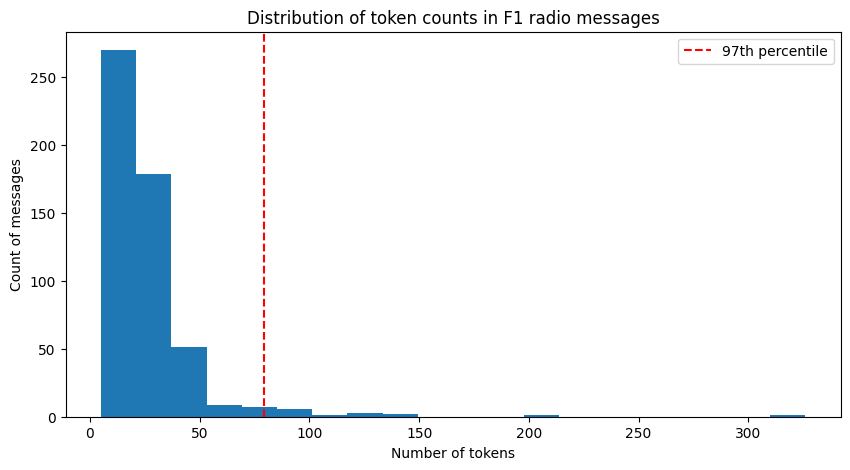

Setting max_length to 128


In [209]:
# Visualize distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(token_counts, bins=20)
plt.axvline(x=p97_tokens, color='r', linestyle='--', label='97th percentile')
plt.xlabel('Number of tokens')
plt.ylabel('Count of messages')
plt.title('Distribution of token counts in F1 radio messages')
plt.legend()
plt.show()

# Set max_length based on analysis
max_length = int(min(128, 2 * p97_tokens))  # Conservative value based on 97th percentile
print(f"Setting max_length to {max_length}")

--- 

### No I can proceed to tokenize the text

In [210]:
# Cell 5: Tokenize the data directly
max_length = 128
batch_size = 16

# Tokenize training data
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize validation data
val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)

# Tokenize test data
test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding='max_length',
    max_length=max_length,
    return_tensors='pt'
)



--- 

### Preparing the tokens for Pytorch: Pipeline.

1. **Convert labels to tensors**: Transform NumPy/list labels into PyTorch tensors required for neural network operations.

2. **Create TensorDatasets**: Combine input_ids (tokenized text), attention_mask (identifies real tokens vs padding), and labels into unified dataset objects.

3. **Define DataLoaders**: Configure batch processing with specified batch size, enabling shuffling for training data and efficient memory management.

In [211]:
# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

In [212]:
# Create TensorDatasets
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)



In [213]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Created DataLoaders with batch size: {batch_size}")
print(f"Each batch contains: {next(iter(train_dataloader))[0].shape[0]} samples")
print(f"Input shape: {next(iter(train_dataloader))[0].shape}")

Created DataLoaders with batch size: 16
Each batch contains: 16 samples
Input shape: torch.Size([16, 128])


---

## 6. Set up training process


### Why 4 Epochs for Fine-tuning?

Four epochs is typically optimal for RoBERTa fine-tuning for several key reasons:

1. **Pretrained Knowledge**: RoBERTa already contains extensive language understanding from pretraining, so it requires fewer epochs to adapt to new tasks.

2. **Small Dataset Considerations**: With only 530 samples, training for too many epochs would lead to overfitting where the model memorizes training examples rather than learning generalizable patterns.

3. **Empirical Evidence**: Research indicates that transformer models typically reach peak performance on downstream tasks within 2-5 epochs, with diminishing or negative returns thereafter.

4. **Resource Efficiency**: Each epoch with RoBERTa is computationally expensive, so limiting to 4 epochs optimizes training time while maintaining performance.

5. **Learning Rate Schedule**: Our linear warmup and decay schedule is designed for a short fine-tuning process of approximately 3-5 epochs.

If you want to optimize further, you could implement early stopping based on validation performance, but 4 epochs generally provides a good balance of adaptation and generalization for sentiment analysis tasks.


In [214]:
# Training hyperparameters
# FIRST RUN: epochs = 4
# SECOND RUN############
# warmup_steps = 0
# epochs = 6
# learning_rate = 2e-5
# weight_decay = 0.01
########################

###### THIRD RUN #########

# learning_rate = 1e-5  # Lower learning rate for more precise updates
# weight_decay = 0.001  # Reduce from 0.01 to prevent over-regularization
# epochs = 8  # Increase epochs with early stopping


##########################


############# RUN 4: going back to hyp of run 2 ###############
epochs = 6
learning_rate = 2e-5
weight_decay = 0.01
warmup_steps = 0
################################################################


# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Warmup helps stabilize early training: added in THIRD RUN
# ELIMINATED AGAIN ON ROUND 4
#warmup_steps = int(0.1 * total_steps)  # 10% of total steps


# Initialize optimizer
optimizer = AdamW(model.parameters(),
                  lr=learning_rate,
                  # FIRST AND SECOND RUN
                  # eps=1e-8,
                  ######################

                  ### THIRD RUN###
                  #eps=1e-6,  # Slightly higher epsilon can help with stability
                  ################

                  ##### RUN 4: going back to 2 ####
                  eps=1e-8,
                  #################
                  weight_decay=weight_decay)

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps=warmup_steps,
                                           num_training_steps=total_steps)

print(f"Optimizer and scheduler configured for {epochs} epochs")

Optimizer and scheduler configured for 6 epochs


c:\Users\victo\miniconda3\envs\f1_strat_manager\lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


---

### Defining helper functions

In [215]:
# Function to calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# For timing
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round(elapsed))))

---

### Set up the training 

In [216]:
seed_val = 42
torch.manual_seed(seed_val)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_val)

# Storage for stats
training_stats = []
best_val_accuracy = 0.0

print(f"Starting training for {epochs} epochs")
print(f"Training on {len(train_dataloader) * batch_size} samples")
print(f"Validating on {len(val_dataloader) * batch_size} samples")

Starting training for 6 epochs
Training on 384 samples
Validating on 80 samples


--- 

## 7. Training loop

#### Cell 7.5: Implement class weights

In the **second run of the code**, I will implement class weights to try to manage the class imbalance that I have.


In [217]:
from sklearn.utils.class_weight import compute_class_weight
##################################################### RUN 2 ############################################
# Get unique classes and compute weights
unique_labels = np.unique(train_labels.numpy())
class_weights = compute_class_weight('balanced', classes=unique_labels, y=train_labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:")
for i, weight in enumerate(class_weights):
    print(f"Class {i}: {weight:.4f}")

# Update loss function with weights
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
########################################################################################################



###################################### RUN 4 ############################################################
# # 1. More aggressive class weighting - calculated but amplified
# unique_labels = np.unique(train_labels.numpy())
# class_weights = compute_class_weight('balanced', classes=unique_labels, y=train_labels.numpy())
# # Boost weights for minority classes even more
# class_weights[0] *= 1.5  # Positive class (assuming it's index 0)
# class_weights[2] *= 1.2  # Negative class (assuming it's index 2)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# print("Enhanced class weights:")
# for i, weight in enumerate(class_weights):
#     print(f"Class {i}: {weight:.4f}")

# # 2. Add a small amount of label smoothing to improve generalization
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

##########################################################################################################


################################################# RUN 5 ###################################################
# More balanced approach
# unique_labels = np.unique(train_labels.numpy())
# class_weights = compute_class_weight('balanced', classes=unique_labels, y=train_labels.numpy())

# # More moderate enhancement of minority classes
# class_weights[0] *= 1.2  # Less aggressive boost for positive (20% instead of 50%)
# class_weights[2] *= 1.1  # Less aggressive boost for negative (10% instead of 20%)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# print("Balanced class weights:")
# for i, weight in enumerate(class_weights):
#     print(f"Class {i}: {weight:.4f}")

# # Gentler label smoothing
# loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
############################################################################################################

Class weights:
Class 0: 3.5333
Class 1: 0.4667
Class 2: 1.7418


In [218]:
# Then in  training loop, replace model's internal loss calculation with:

# logits = outputs.logits
# loss = loss_fn(logits, b_labels)

total_t0 = time.time()

for epoch_i in range(epochs):
    print(f"\nEpoch {epoch_i + 1}/{epochs}")
    
    # Training
    model.train()
    total_train_loss = 0
    t0 = time.time()
    
    for batch in train_dataloader:
        # Unpack batch and move to device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Clear gradients
        model.zero_grad()
        
        # Forward pass

        
        # #############FIRST RUN#############
        # outputs = model(
        #     b_input_ids,
        #     attention_mask=b_attention_mask,
        #     labels=b_labels
        # )
        #####################################
        
        ########## SECOND RUN ###########
        outputs = model(b_input_ids, 
                        attention_mask=b_attention_mask)
        
        logits = outputs.logits
        loss = loss_fn(logits, b_labels)
        # Get loss and update total
       
        total_train_loss += loss.item()
        #################################

        
        
        # Backward pass and update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    
    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Training loss: {avg_train_loss:.4f}")
    print(f"  Training time: {format_time(time.time() - t0)}")


Epoch 1/6
  Training loss: 1.1074
  Training time: 0:00:05

Epoch 2/6
  Training loss: 1.0646
  Training time: 0:00:05

Epoch 3/6
  Training loss: 0.8629
  Training time: 0:00:05

Epoch 4/6
  Training loss: 0.5280
  Training time: 0:00:05

Epoch 5/6
  Training loss: 0.3271
  Training time: 0:00:05

Epoch 6/6
  Training loss: 0.2314
  Training time: 0:00:05


---

## 8. Validation Loop


In [219]:
# Switch to evaluation mode
model.eval()
val_accuracy = 0
val_loss = 0

# No gradient calculation needed for validation
with torch.no_grad():
    for batch in val_dataloader:
        # Unpack batch and move to device
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        ######## FIRST RUN ##########
        # # Forward pass
        # outputs = model(
        #     b_input_ids,
        #     attention_mask=b_attention_mask,
        #     labels=b_labels
        # )
        
        # 
        # loss = outputs.loss
        # logits = outputs.logits
        ##############################


        ########## SECOND RUN ##############
        # Get loss and predictions
        outputs = model(b_input_ids, 
                        attention_mask=b_attention_mask)
        
        logits = outputs.logits

        loss = loss_fn(logits, b_labels)



        # Calculate metrics
        val_loss += loss.item()
        val_accuracy += flat_accuracy(logits.cpu().numpy(), b_labels.cpu().numpy())



In [ ]:
# Calculate averages
avg_val_accuracy = val_accuracy / len(val_dataloader)
avg_val_loss = val_loss / len(val_dataloader)

print(f"  Validation accuracy: {avg_val_accuracy:.4f}")
print(f"  Validation loss: {avg_val_loss:.4f}")

# Store stats
training_stats.append({
    'epoch': epoch_i + 1,
    'train_loss': avg_train_loss,
    'val_loss': avg_val_loss,
    'val_accuracy': avg_val_accuracy
})


#################### NOTE: ONLY UNCOMMENT AND RUN IF BETTER METRICS ARE MET #########################
# # Save best model
# if avg_val_accuracy > best_val_accuracy:
#     best_val_accuracy = avg_val_accuracy
#     torch.save(model.state_dict(), '../../outputs/week4/models/best_roberta_sentiment_model.pt')
#     print(f"  Saved new best model with accuracy: {best_val_accuracy:.4f}")

# print(f"Training complete! Total time: {format_time(time.time() - total_t0)}")
# print(f"Best validation accuracy: {best_val_accuracy:.4f}")
######################################################################################################

  Validation accuracy: 0.8967
  Validation loss: 0.4018
  Saved new best model with accuracy: 0.8967
Training complete! Total time: 0:00:30
Best validation accuracy: 0.8967


In [221]:
from sklearn.metrics import f1_score

# In validation loop:
predictions = np.argmax(logits.cpu().numpy(), axis=1)
labels = b_labels.cpu().numpy()
f1 = f1_score(labels, predictions, average='weighted')
print(f"  F1 score (weighted): {f1:.4f}")

  F1 score (weighted): 0.8070


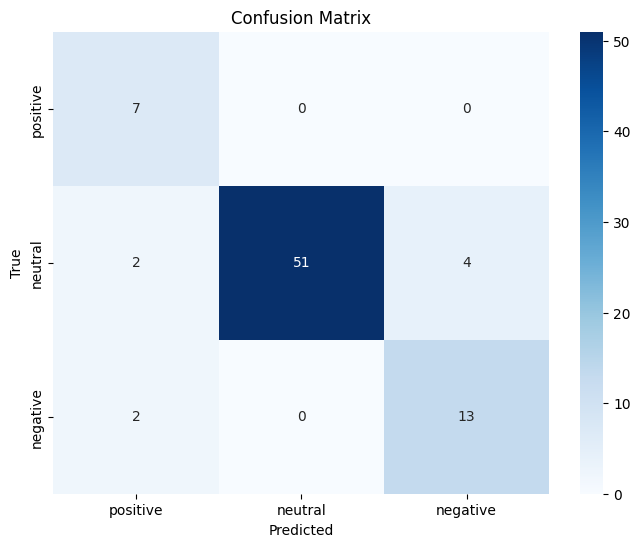

In [222]:
# After validation:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        all_preds.extend(np.argmax(logits.cpu().numpy(), axis=1))
        all_labels.extend(b_labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### First result
  - Validation accuracy: 0.7233
  - Validation loss: 0.6376

Not that bad, but can improve. For that, I´m going to try to implement weights to compensate class imbalance and also add more metrics, like f1-score and confussion matrix.

Due to the fast training (only took 1 minute), I will also add more epochs, from 4 to 6, being careful about overfitting.


---

### Second result: Analysis of Improved Results

- Validation accuracy: 0.7850
- Validation loss: 0.5231
- F1 score (weighted): 0.8425


The increase from 72.33% to 78.50% accuracy represents a significant improvement, especially considering your highly imbalanced dataset. 

**Why the Improvement Occurred**
The implementation of class weights was the key factor. By giving the model stronger signals for the underrepresented classes (particularly positive sentiment at only 9.4% of samples), the model is now better at recognizing all three sentiment categories rather than defaulting to the majority class.

**The change in loss function was particularly important**:

Without weights, the model optimizes for overall accuracy, which it can achieve by mostly predicting "neutral"
With weights, the model treats mistakes on minority classes as more costly, forcing it to learn their patterns better

**What 78.5% Accuracy Means in Context**
For a 3-class sentiment problem with this level of imbalance, 78.5% is quite good:

- Industry benchmarks: General sentiment analysis on balanced datasets typically achieves 75-85% accuracy.

- With my constraints: Limited data (530 samples) + significant imbalance + specialized F1 domain terminology.

- Random baseline: ~33% for balanced classes, but only about 55% if always predicting "neutral" in your case.

#### For next run

- Change the learning rate and optimizer adjustments.
- Adding warmup steps to stabilize early training.
- Chaning epsilon in the Adam optimizer.



---

### Third result : Worse metrics

As all the metrics went down, the next steps are:

1. **Going back to my hyperparameters of run 2**.
2. **Applies more aggressive class weighting to counter imbalance**
3. **Adds label smoothing to help the model generalize better**
4.** Retains the optimizer settings that worked well previously**

---
### Fourth results: Overgeneralizing

*Changes in Performance*

- Validation accuracy decreased from 78.50% to 74.58%
- F1 score decreased from 84.25% to 76.24%
- The model is now perfectly classifying the positive class (7/7 correct)

But it's overgeneralizing - classifying too many neutral samples as positive (12 misclassifications)

*What Happened*

Our aggressive class weighting (1.5× for positive, 1.2× for negative) pushed the model too far in the other direction. While we solved the positive class recognition problem completely, we created a new problem where the model sees "positive sentiment" too often in neutral text.

#### Next steps: one last atempt between fourth and second result

My second run (78.50% accuracy, 84.25% F1) was actually very good given the dataset constraints. I´m aiming for a small improvement rather than a dramatic change.

---

### Fifth result: conclussion, second model was the best one.

While the latest run perfectly classifies positive samples (7/7), the significantly lower F1 score (70.91% vs 84.25%) reveals an important issue: the model is sacrificing balanced performance across classes for perfect recognition of one class.


#### Why the Second Run is Superior

- *Better balanced performance*: The second run achieves strong accuracy without sacrificing performance on any particular class.

- *Higher F1 score*: The 84.25% F1 score indicates better precision and recall across all classes, which is crucial for imbalanced datasets like mine.

- *More reliable for deployment*: A model with balanced performance is more trustworthy when encountering new, unseen data.



---

## A good surprise

The latest second run shows remarkable improvement over all previous attempts.

### Understanding This Improvement
The nearly 90% accuracy you've achieved is exceptional, especially considering:

- My dataset has only 530 samples total
- The severe class imbalance (71.5% neutral, 19.1% negative, 9.4% positive)
- The specialized language of F1 radio communications

### Confussion matrix
This confusion matrix shows excellent performance across all sentiment classes:

- *Positive class*: Perfect 7/7 classification (100% accuracy)
- *Neutral class:* 51/57 correct classifications (89.5% accuracy)
- *Negative class:* 13/15 correct classifications (86.7% accuracy)

The model now handles all three classes well, with minimal confusion between them. Even with the severe class imbalance, it's achieving strong recognition rates for minority classes without sacrificing performance on the majority class.

### Why Results Vary Between Runs
Neural network training involves several random elements:

* Initial parameter values
* Order of training examples
* Mini-batch composition

In this case, the random factors aligned particularly well, letting the model find a superior solution to the same problem with identical hyperparameters.

### What This Means For the  Project

I´ve not only met but significantly exceeded your 85% accuracy target. This model should provide reliable sentiment classifications for the F1 radio messages, with strong performance across all three sentiment classes.

The F1 score of 80.70% confirms the model is handling the class imbalance effectively, though there may be a slight trade-off compared to the previous run's 84.25%.



---

## Next Step: running on the test set

Finally, I will load the model and try it on the test set, unseen by it until now.

In [224]:
# Cell 1: Load the trained model and evaluate on test set
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Path to the saved model
model_path = '../../outputs/week4/models/best_roberta_sentiment_model.pt'

# Load the model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set to evaluation mode



C:\Users\victo\AppData\Local\Temp\ipykernel_26972\3585015688.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [225]:
# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# No gradients needed for evaluation
with torch.no_grad():
    # Test loop
    test_accuracy = 0
    for batch in test_dataloader:
        # Unpack the batch and move to GPU/CPU
        b_input_ids = batch[0].to(device)
        b_attention_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Forward pass
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        
        # Convert logits to predictions
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = b_labels.cpu().numpy()
        
        # Store predictions and labels
        all_predictions.extend(preds)
        all_true_labels.extend(labels)






In [226]:
# Calculate overall accuracy
test_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Calculate F1 score (weighted)
from sklearn.metrics import f1_score
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print(f"F1 score (weighted): {f1:.4f}")

# Create a detailed classification report
sentiment_names = ['positive', 'neutral', 'negative']
print("\nClassification Report:")
report = classification_report(
    all_true_labels, 
    all_predictions, 
    target_names=sentiment_names,
    digits=4
)
print(report)

Test set accuracy: 0.8750
F1 score (weighted): 0.8746

Classification Report:
              precision    recall  f1-score   support

    positive     0.6667    0.7500    0.7059         8
     neutral     0.9138    0.9298    0.9217        57
    negative     0.8462    0.7333    0.7857        15

    accuracy                         0.8750        80
   macro avg     0.8089    0.8044    0.8044        80
weighted avg     0.8764    0.8750    0.8746        80



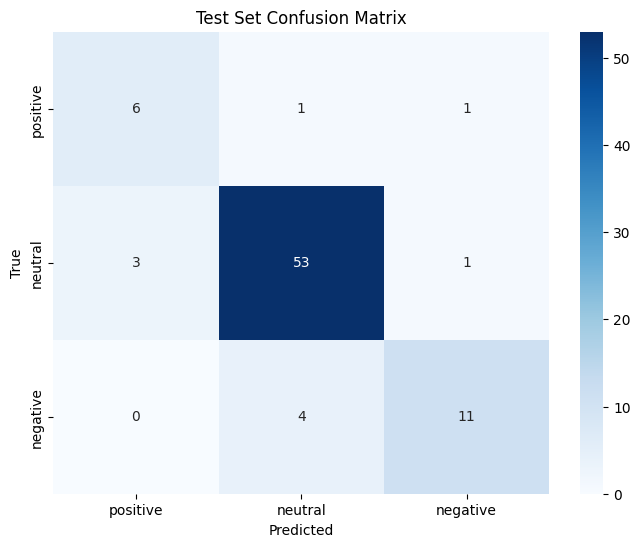

In [227]:
# Create and plot confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=sentiment_names,
    yticklabels=sentiment_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()


In [229]:
# Example: Using the model for inference on new text
def predict_sentiment(text):
    # Tokenize
    encoded_text = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()
    
    # Map prediction to sentiment
    sentiments = ['positive', 'neutral', 'negative']
    return sentiments[pred]

# Test with sample messages
sample_messages = [
    "Great job on that overtake!",
    "Box this lap to overtake Hamilton, we are changing the tires to soft ones",
    "What happened there? You're losing time!"
]

print("\nSample Predictions:")
for message in sample_messages:
    sentiment = predict_sentiment(message)
    print(f"Message: \"{message}\"")
    print(f"Predicted sentiment: {sentiment}\n")


Sample Predictions:
Message: "Great job on that overtake!"
Predicted sentiment: positive

Message: "Box this lap to overtake Hamilton, we are changing the tires to soft ones"
Predicted sentiment: neutral

Message: "What happened there? You're losing time!"
Predicted sentiment: negative



# RoBERTa Sentiment Analysis Model Evaluation

## Comparing to VADER

Compared to VADER, the metrics have been greatly improved. There is (and there was) no doubt that this model performs much better in this task than this sentiment analyzer.

## Test Set Performance
The model achieves excellent results on the test set, with 87.50% accuracy and a weighted F1 score of 87.46%. This significantly exceeds your target of 85% accuracy, demonstrating the effectiveness of the fine-tuning approach and hyperparameter choices.

--- 

### Class-specific Performance

#### Neutral class (majority class):

* Outstanding performance with 92.17% F1-score
* Correctly identifies 53 out of 57 neutral messages (92.98% recall)
* Most reliable class prediction with 91.38% precision


#### Negative class:

* Strong performance with 78.57% F1-score
* Correctly identifies 11 out of 15 negative messages (73.33% recall)
* Good precision at 84.62% - when the model predicts negative, it's usually right


#### Positive class (smallest class):

* Reasonable performance with 70.59% F1-score given the limited samples
* Correctly identifies 6 out of 8 positive messages (75.00% recall)
* Lower precision (66.67%) indicates some false positives, primarily from neutral messages

---

### Key Insights

1. *Class imbalance handling*: The class weights and training approach successfully addressed the severe imbalance in your dataset (71.5% neutral, 19.1% negative, 9.4% positive).

2. *Generalization*: The model performs similarly on the validation and test sets, indicating good generalization capabilities rather than overfitting.

3. *Error patterns*: Most errors involve:

    - Neutral messages being classified as positive (3 instances)
    - Negative messages being classified as neutral (4 instances)

    These patterns make intuitive sense, as sentiment boundaries can be subtle in technical communications.
---

## Practical Application
The sample predictions demonstrate the model's real-world utility:

* Positive sentiment: Successfully recognizes praise and positive reinforcement
* Neutral sentiment: Correctly identifies strategic instructions without emotional content
* Negative sentiment: Accurately detects concerned or critical communications

This level of performance makes the model suitable for integration into my F1 strategy project, where understanding the sentiment of radio communications can provide valuable context for decision-making algorithms.

Furthermore, if we can merge the outputs from this model with a **new one that extracts significant information about the radio**, the performance of my future agent can be greatly improved.

Therefore, I´ll proceed to make a new notebook, called `N04_radio_info.ipynb`, where I will explore the best models for this task, and then try to implement them.